In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [4]:
claims = pd.read_csv('Medicare_Part_D_Spending_by_Drug_2022.csv')

In [5]:
claims = claims.dropna()

In [6]:
numeric_cols = ["Tot_Spndng_2021", "Tot_Dsg_Unts_2021", "Tot_Clms_2021", "Tot_Benes_2021", 
                "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021", "Avg_Spnd_Per_Clm_2021", "Avg_Spnd_Per_Bene_2021", 
                "Tot_Spndng_2022", "Tot_Dsg_Unts_2022", "Tot_Clms_2022", "Tot_Benes_2022", 
                "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022", "Avg_Spnd_Per_Clm_2022", "Avg_Spnd_Per_Bene_2022", 
                "Chg_Avg_Spnd_Per_Dsg_Unt_21_22"]

# Using .loc and replacing symbols in a chain to prevent SettingWithCopyWarning
for col in numeric_cols:
    claims.loc[:, col] = claims[col].astype(str).str.replace("$", "", regex=False).str.replace(",", "", regex=False).str.replace("%", "", regex=False)
    # Convert back to numeric after removing special characters
    claims.loc[:, col] = pd.to_numeric(claims[col], errors='coerce')


## Random Forest Analysis (2021 Data)

In [7]:
claim_2021_cols = ["Brnd_Name", "Tot_Mftr", "Mftr_Name", "Tot_Spndng_2021", "Tot_Dsg_Unts_2021", "Tot_Clms_2021", "Tot_Benes_2021", "Avg_Spnd_Per_Dsg_Unt_Wghtd_2021", "Avg_Spnd_Per_Clm_2021", "Avg_Spnd_Per_Bene_2021", "Outlier_Flag_2021"]

claim_2022_cols = ["Brnd_Name", "Tot_Mftr", "Mftr_Name", "Tot_Spndng_2022", "Tot_Dsg_Unts_2022", "Tot_Clms_2022", "Tot_Benes_2022", "Avg_Spnd_Per_Dsg_Unt_Wghtd_2022", "Avg_Spnd_Per_Clm_2022", "Avg_Spnd_Per_Bene_2022", "Outlier_Flag_2022"]



claims_2021 = claims[claim_2021_cols]
claims_2022 = claims[claim_2022_cols]

In [8]:
non_numeric_cols = ["Brnd_Name", "Tot_Mftr", "Mftr_Name", "Outlier_Flag_2021"]

# Split the data into features (X) and target (y)
X = claims_2021.drop(non_numeric_cols, axis=1)
y = claims_2021["Outlier_Flag_2021"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((7284, 7), (1822, 7))

### Vefrifying Class Distribution

In [9]:
# Check the distribution of the target variable after SMOTE
from collections import Counter

class_distribution = Counter(y_train)
print("Class Distribution:", class_distribution)


Class Distribution: Counter({0.0: 6869, 1.0: 415})


In [10]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

# predict the mode
y_pred = model.predict(X_test)

# performance evaluation metrics
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98      1776
         1.0       0.44      0.96      0.60        46

    accuracy                           0.97      1822
   macro avg       0.72      0.96      0.79      1822
weighted avg       0.98      0.97      0.97      1822



### Hyperparameter Tuning

In [77]:
param_grid = { 
	'n_estimators': [25, 50, 100, 150], 
	'max_features': ['sqrt', 'log2', None], 
	'max_depth': [3, 6, 9], 
	'max_leaf_nodes': [3, 6, 9], 
} 


In [78]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid) 

grid_search.fit(X_train, y_train) 

print(grid_search.best_estimator_) 

KeyboardInterrupt: 

### Updating the Model

In [ ]:
# Now we will update the parameters of the model by those which are obtained by using GridSearchCV.

model_grid = RandomForestClassifier(max_depth=9, 
									max_features="log2", 
									max_leaf_nodes=9, 
									n_estimators=25) 
model_grid.fit(X_train, y_train) 
y_pred_grid = model.predict(X_test) 
print(classification_report(y_pred_grid, y_test)) 
print("Accuracy: ", accuracy_score(y_pred_grid, y_test))


# Feature Importance
importance_before = model_grid.feature_importances_

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1691
         1.0       0.67      0.52      0.59       131

    accuracy                           0.95      1822
   macro avg       0.82      0.75      0.78      1822
weighted avg       0.94      0.95      0.94      1822

Accuracy:  0.9473106476399561


### SMOTE Analysis

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train Random Forest on resampled data
model_smote = RandomForestClassifier()
model_smote.fit(X_resampled, y_resampled)

RandomForestClassifier()

### Verifying Class Distribution After SMOTE

In [12]:
class_distribution = Counter(y_resampled)
print("Class Distribution After SMOTE:", class_distribution)

Class Distribution After SMOTE: Counter({0.0: 6869, 1.0: 6869})


In [13]:
y_pred_smote = model_smote.predict(X_test)

print(classification_report(y_pred_smote, y_test))
print("Accuracy: ", accuracy_score(y_pred_smote,y_test))

# Feature Importance
importance_after = model_smote.feature_importances_

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      1685
         1.0       0.68      0.50      0.58       137

    accuracy                           0.95      1822
   macro avg       0.82      0.74      0.78      1822
weighted avg       0.94      0.95      0.94      1822

Accuracy:  0.9451152579582875


In [14]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Before_SMOTE': importance_before,
    'After_SMOTE': importance_after
}).set_index('Feature')

feature_importance_df.plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance Before and After SMOTE')
plt.ylabel('Importance')
plt.show()


NameError: name 'importance_before' is not defined

## Random Forest Analysis (2022 Data)

In [15]:
non_numeric_cols_2022 = ["Brnd_Name", "Tot_Mftr", "Mftr_Name", "Outlier_Flag_2022"]

# Split the data into features (X) and target (y)
X = claims_2022.drop(non_numeric_cols_2022, axis=1)
y = claims_2022["Outlier_Flag_2022"]

# Split the data into training and test sets
X_train_2022, X_test_2022, y_train_2022, y_test_2022 = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_2022.shape, X_test_2022.shape

((7284, 7), (1822, 7))

### Vefrifying Class Distribution (2022 Data)

In [16]:
# Check the distribution of the target variable after SMOTE
from collections import Counter

class_distribution = Counter(y_train_2022)
print("Class Distribution:", class_distribution)

Class Distribution: Counter({0.0: 6725, 1.0: 559})


In [20]:
model_2022 = RandomForestClassifier()
model_2022.fit(X_train_2022, y_train_2022)

# predict the mode
y_pred_2022 = model_2022.predict(X_test_2022)

# performance evaluation metrics
print(classification_report(y_pred_2022,y_test_2022))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98      1752
         1.0       0.48      0.84      0.61        70

    accuracy                           0.96      1822
   macro avg       0.74      0.90      0.80      1822
weighted avg       0.97      0.96      0.96      1822



### Hyperparameter Tuning

In [ ]:
param_grid_2022 = { 
	'n_estimators': [25, 50, 100, 150], 
	'max_features': ['sqrt', 'log2', None], 
	'max_depth': [3, 6, 9], 
	'max_leaf_nodes': [3, 6, 9], 
} 


grid_search_2022 = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_2022) 

grid_search_2022.fit(X_train_2022, y_train_2022) 

print(grid_search_2022.best_estimator_) 

RandomForestClassifier(max_depth=9, max_leaf_nodes=6, n_estimators=50)


### Updating the model

In [ ]:
# Now we will update the parameters of the model by those which are obtained by using GridSearchCV.

model_grid_2022 = RandomForestClassifier(max_depth=9, 
									max_features="log2", 
									max_leaf_nodes=6, 
									n_estimators=50) 
model_grid_2022.fit(X_train_2022, y_train_2022) 
y_pred_grid_2022 = model_grid_2022.predict(X_test_2022) 
print(classification_report(y_pred_grid_2022, y_test_2022)) 
print("Accuracy: ", accuracy_score(y_pred_grid_2022, y_test_2022))


# Feature Importance
importance_before_2022 = model_grid_2022.feature_importances_

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97      1781
         1.0       0.29      0.85      0.43        41

    accuracy                           0.95      1822
   macro avg       0.64      0.90      0.70      1822
weighted avg       0.98      0.95      0.96      1822

Accuracy:  0.9489571899012075


### SMOTE Analysis

In [21]:
# Apply SMOTE
smote_2022 = SMOTE(random_state=42)
X_resampled_2022, y_resampled_2022 = smote_2022.fit_resample(X_train_2022, y_train_2022)

# Train Random Forest on resampled data
model_smote_2022 = RandomForestClassifier()
model_smote_2022.fit(X_resampled_2022, y_resampled_2022)

RandomForestClassifier()

### Verifying Class Distriubtion After SMOTE

In [22]:
class_distribution_2022 = Counter(y_resampled_2022)
print("Class Distribution After SMOTE:", class_distribution_2022)

Class Distribution After SMOTE: Counter({0.0: 6725, 1.0: 6725})


In [23]:
y_pred_smote_2022 = model_smote_2022.predict(X_test_2022)

print(classification_report(y_pred_smote_2022, y_test_2022))
print("Accuracy: ", accuracy_score(y_pred_smote_2022,y_test_2022))

# Feature Importance
importance_after_2022 = model_smote_2022.feature_importances_

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.96      1639
         1.0       0.66      0.44      0.52       183

    accuracy                           0.92      1822
   macro avg       0.80      0.71      0.74      1822
weighted avg       0.91      0.92      0.91      1822

Accuracy:  0.920417124039517


In [24]:
feature_importance_2022_df = pd.DataFrame({
    'Feature': X_train_2022.columns,
    'Before_SMOTE': importance_before_2022,
    'After_SMOTE': importance_after_2022
}).set_index('Feature')

feature_importance_2022_df.plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance Before and After SMOTE (2022 Data)')
plt.ylabel('Importance')
plt.show()

NameError: name 'importance_before_2022' is not defined

## Additional Approaches to Analyze Drug Frauds

### Calculating Fraud Rates for Each Drug

In [41]:
X_test['Predicted_Fraud'] = y_pred
X_test['Actual_Fraud'] = y_test.values  # Add actual fraud labels for comparison


X_test_2022['Predicated_Fraud'] = y_pred_2022
X_test_2022['Actual_Fraud'] = y_test_2022.values  # Add actual fraud labels for comparison

In [ ]:
# Calculate total cases per drug
total_cases_by_drug_2021 = X_test.groupby(claims['Brnd_Name']).size()

# Calculate fraudulent cases per drug
fraud_cases_by_drug_2021 = X_test[X_test['Actual_Fraud'] == 1].groupby(claims['Brnd_Name']).size()

# Compute fraud rates
fraud_rate_by_drug_2021 = (fraud_cases_by_drug_2021 / total_cases_by_drug_2021).fillna(0).sort_values(ascending=False)

# Display the top drugs with the highest fraud rates
print(fraud_rate_by_drug_2021.head(10))

print("\n")


# Calculate total cases per drug
total_cases_by_drug_2022 = X_test_2022.groupby(claims['Brnd_Name']).size()

# Calculate fraudulent cases per drug
fraud_cases_by_drug_2022 = X_test_2022[X_test_2022['Actual_Fraud'] == 1].groupby(claims['Brnd_Name']).size()

# Compute fraud rates
fraud_rate_by_drug_2022 = (fraud_cases_by_drug_2022 / total_cases_by_drug_2022).fillna(0).sort_values(ascending=False)

# Display the top drugs with the highest fraud rates
print(fraud_rate_by_drug_2022.head(10))



Brnd_Name
Gemcitabine HCl           1.0
Ampicillin Sodium*        1.0
Modafinil                 1.0
Rozerem                   1.0
Rowasa                    1.0
Ropinirole ER             1.0
Pfizerpen                 1.0
Inflectra                 1.0
Vancocin HCl              1.0
Eraxis (Water Diluent)    1.0
dtype: float64
Brnd_Name
Glyburide        1.0
Ceftriaxone*     1.0
Cefoxitin        1.0
Cefepime HCl*    1.0
Ofloxacin*       1.0
Tabloid          1.0
Tadalafil        1.0
Teflaro          1.0
Norpace          1.0
Glycate          1.0
dtype: float64


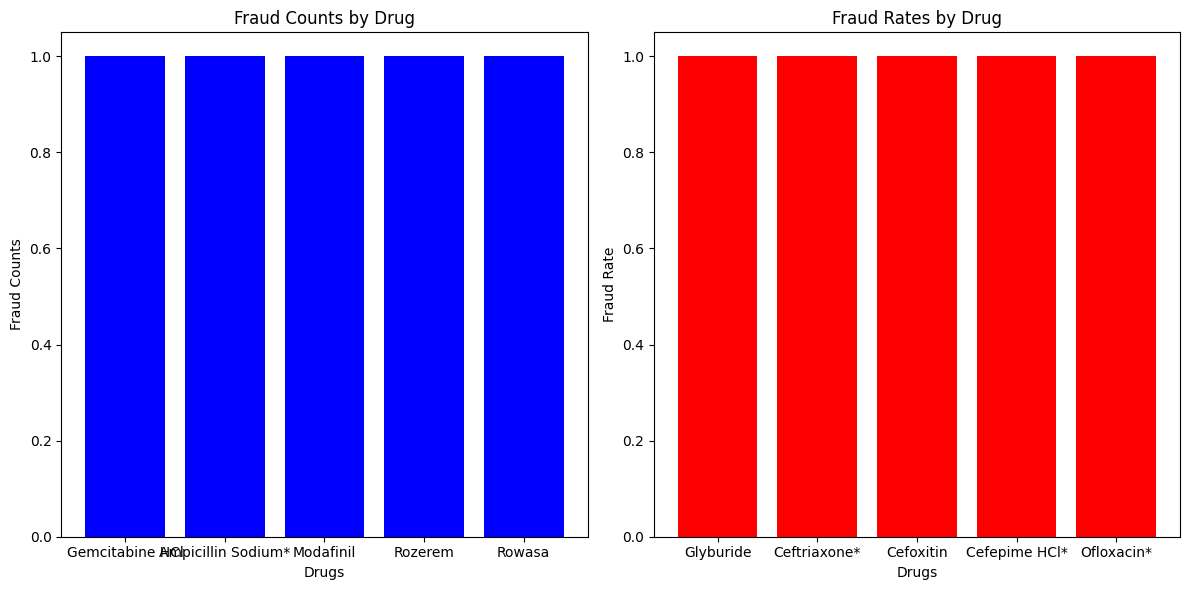

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Bar chart for fraud counts
axes[0].bar(fraud_rate_by_drug_2021.head(5).index, fraud_rate_by_drug_2021.head(5).values , color='blue')
axes[0].set_title('Fraud Rates by Drug 2021')
axes[0].set_xlabel('Drugs')
axes[0].set_ylabel('Fraud Rate')

# Bar chart for fraud rates
axes[1].bar(fraud_rate_by_drug_2022.head(5).index, fraud_rate_by_drug_2022.head(5).values, color='red')
axes[1].set_title('Fraud Rates by Drug 2022')
axes[1].set_xlabel('Drugs')
axes[1].set_ylabel('Fraud Rate')

# Adjust layout
plt.tight_layout()
plt.show()

### Identifying Drugs With High Fraud Counts

In [48]:
# Count fraudulent cases per drug
fraud_counts_by_drug_2021 = X_test[X_test['Actual_Fraud'] == 1].groupby(claims['Brnd_Name']).size().sort_values(ascending=False)

# Display the top drugs with the highest fraud counts
print(fraud_counts_by_drug_2021.head(10))

# Count fraudulent cases per drug
fraud_counts_by_drug_2022 = X_test_2022[X_test_2022['Actual_Fraud'] == 1].groupby(claims['Brnd_Name']).size().sort_values(ascending=False)

# Display the top drugs with the highest fraud counts
print(fraud_counts_by_drug_2022.head(10))

Brnd_Name
Ampicillin Sodium*      3
Voriconazole*           2
Caretouch Pen Needle    2
Eletriptan HBr          2
Ceftriaxone*            2
Acyclovir*              2
Diclofenac Sodium*      2
Avycaz                  2
Aripiprazole            2
Rizatriptan             1
dtype: int64
Brnd_Name
Moxifloxacin HCl      3
Ceftriaxone*          3
Olopatadine HCl*      2
Avycaz                2
Eletriptan HBr        2
Riluzole              2
Ceftazidime           2
Diclofenac Sodium*    2
Aripiprazole          2
Ampicillin Sodium*    2
dtype: int64


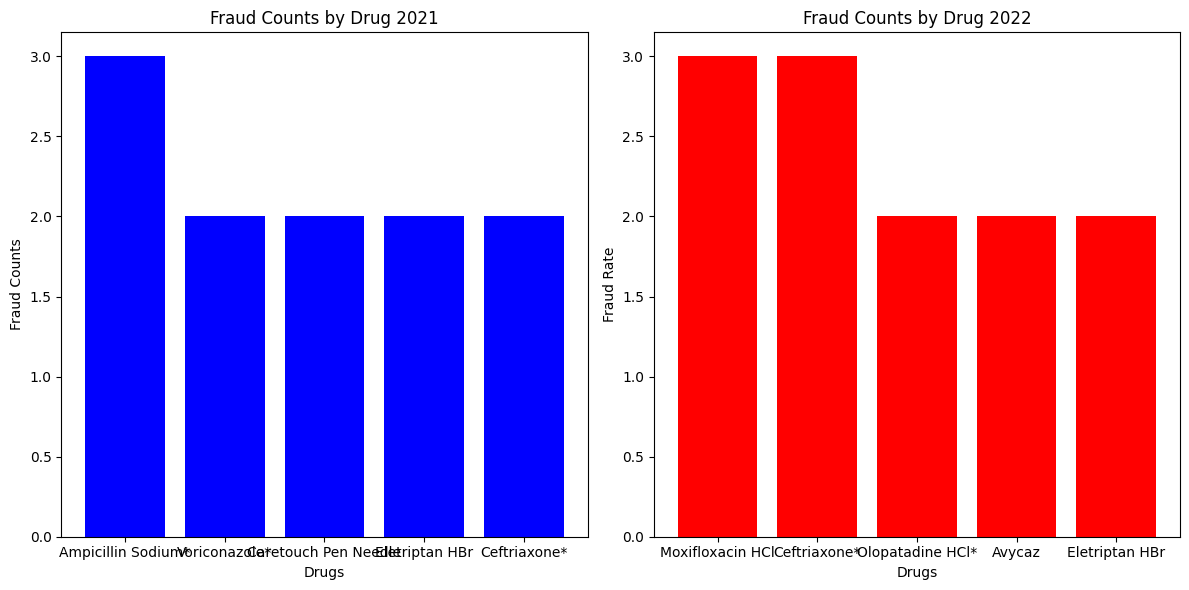

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Bar chart for fraud counts
axes[0].bar(fraud_counts_by_drug_2021.head(5).index, fraud_counts_by_drug_2021.head(5).values , color='blue')
axes[0].set_title('Fraud Counts by Drug 2021')
axes[0].set_xlabel('Drugs')
axes[0].set_ylabel('Fraud Counts')

# Bar chart for fraud rates
axes[1].bar(fraud_counts_by_drug_2022.head(5).index, fraud_counts_by_drug_2022.head(5).values, color='red')
axes[1].set_title('Fraud Counts by Drug 2022')
axes[1].set_xlabel('Drugs')
axes[1].set_ylabel('Fraud Rate')

# Adjust layout
plt.tight_layout()
plt.show()

### Combining the Fraud Rate and Count

In [50]:
fraud_analysis = pd.DataFrame({
    'Fraud Count': fraud_cases_by_drug,
    'Total Cases': total_cases_by_drug,
    'Fraud Rate': fraud_rate_by_drug
}).fillna(0).sort_values(by='Fraud Rate', ascending=False)

# Display the top drugs with the highest fraud rates and counts
print(fraud_analysis.head(10))


                        Fraud Count  Total Cases  Fraud Rate
Brnd_Name                                                   
Gemcitabine HCl                 1.0            1         1.0
Ampicillin Sodium*              3.0            3         1.0
Modafinil                       1.0            1         1.0
Rozerem                         1.0            1         1.0
Rowasa                          1.0            1         1.0
Ropinirole ER                   1.0            1         1.0
Pfizerpen                       1.0            1         1.0
Inflectra                       1.0            1         1.0
Vancocin HCl                    1.0            1         1.0
Eraxis (Water Diluent)          1.0            1         1.0


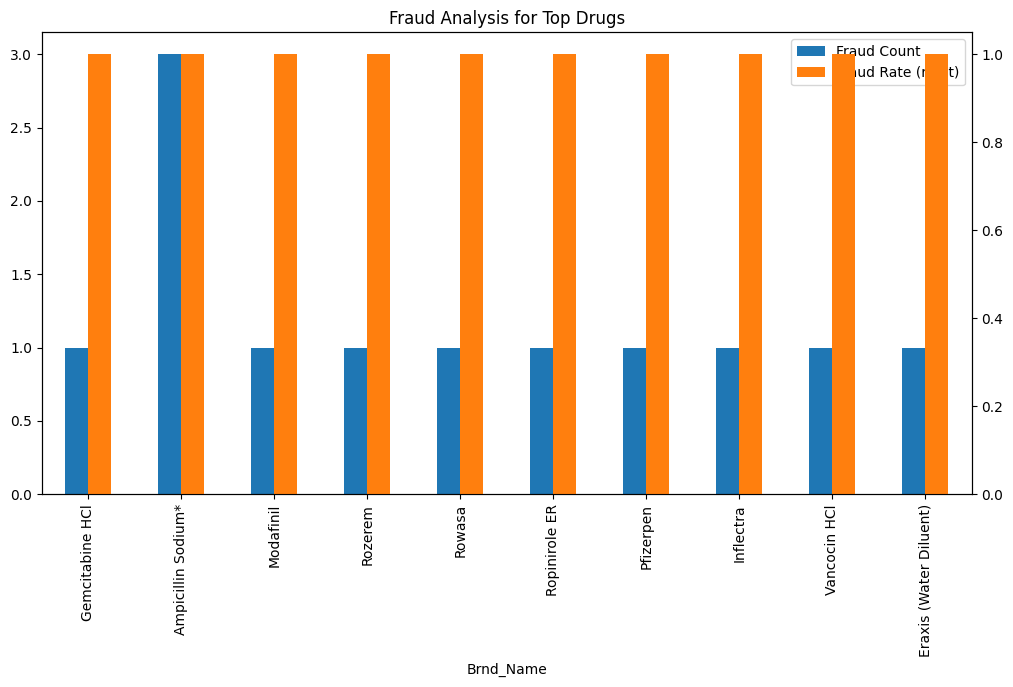

In [51]:
# Plot fraud rate and count side by side for top drugs
fraud_analysis.head(10).plot(
    y=['Fraud Count', 'Fraud Rate'], kind='bar', figsize=(12, 6), secondary_y='Fraud Rate'
)
plt.title("Fraud Analysis for Top Drugs")
plt.xlabel("Drug Name")
plt.xticks(rotation=45)
plt.show()


### Grouping by Manufacturers

In [53]:
# Calculate fraud counts and rates for manufacturers
total_cases_by_manufacturer = X_test.groupby(claims['Mftr_Name']).size()
fraud_cases_by_manufacturer = X_test[X_test['Actual_Fraud'] == 1].groupby(claims['Mftr_Name']).size()

fraud_rate_by_manufacturer = (fraud_cases_by_manufacturer / total_cases_by_manufacturer).fillna(0).sort_values(ascending=False)

# Combine metrics for manufacturers
fraud_analysis_manufacturer = pd.DataFrame({
    'Fraud Count': fraud_cases_by_manufacturer,
    'Total Cases': total_cases_by_manufacturer,
    'Fraud Rate': fraud_rate_by_manufacturer
}).fillna(0).sort_values(by='Fraud Rate', ascending=False)

# Display the top manufacturers with the highest fraud rates
print(fraud_analysis_manufacturer.head(10))


                  Fraud Count  Total Cases  Fraud Rate
Mftr_Name                                             
Pfizer/Novaplus           1.0            1         1.0
Cephazone Pharm*          1.0            1         1.0
Orchid/Bionphar           1.0            1         1.0
Ferring Ph Inc*           1.0            1         1.0
Genzyme                   1.0            1         1.0
Cambridge Thera           1.0            1         1.0
App/Fresenius K*          1.0            1         1.0
Alcon Laborator           1.0            1         1.0
Akorn Inc.*               1.0            1         1.0
Future Diagnost           1.0            1         1.0
